## Initializations
Import Packages

In [1]:
import sys
sys.path.append('..')

import json
from tqdm import tqdm
from pathlib import Path


from msanet.model import SoyModel
from msanet.dataset import Soy
from msanet.utils import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import imageio.v3 as iio

import math
from skimage.feature import peak_local_max

/home/ddgi/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load MSANet Pretrained Weight

In [2]:
model = SoyModel(pretrained=False)
checkpoint = torch.load('../runs/pre_trained/ckpt/best_mae.pth')
model_weight = checkpoint["model_state_dict"]
model.load_state_dict(model_weight)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

transform = A.Compose(
    [   
        A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, position=A.PadIfNeeded.PositionType.TOP_LEFT,border_mode=cv2.BORDER_CONSTANT, value=0),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


/home/ddgi/miniconda3/envs/torch/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


## Evaluation on 2021 images_b

In [3]:
p = Path('../data/2021_dataset/')
json_list = [item.absolute() for item in p.glob('**/*.json') if '_b' in item.stem]

model.eval()
gts = []
preds = []
ames = []
precisions = []
recalls = []

with torch.no_grad():
    for json_path in tqdm(json_list):
        with open(json_path, 'r') as f:
            json_file = json.load(f)

        img_name = json_file['item']['slots'][0]['source_files'][0]['file_name']
        img_path = f'../data/2021_dataset/{img_name}'

        img = iio.imread(img_path)
        points = get_points(json_file)
        img_tensor = transform(image=img)['image'].unsqueeze(0).to(device)

        bx0 = model(img_tensor, inference=True)
        rst = bx0.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        coordinates = peak_local_max(rst[..., 0], min_distance=10, threshold_abs=0.1)
    
        matched_distances_nn_cdist, matched_indices_pred_cdist, matched_indices_gt_cdist = matching(coordinates, points, match_threshold=25)

        ame = matched_distances_nn_cdist.sum() / len(matched_distances_nn_cdist)
        precision = len(matched_indices_pred_cdist) / len(coordinates)
        recall = len(matched_indices_pred_cdist) / len(points)
        
        ames.append(ame)
        precisions.append(precision)
        recalls.append(recall)

        preds.append(len(coordinates))
        
        annotations = json_file['annotations']
        gts.append(len(points))

100%|██████████| 132/132 [00:15<00:00,  8.53it/s]


In [4]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gts, preds)
r2 = r_value ** 2
mae = mean_absolute_error(gts, preds)
mse = mean_squared_error(gts, preds)
rmse = math.sqrt(mse)
mame = sum(ames) / len(ames)
mprecisions = sum(precisions) / len(precisions)
mrecall = sum(recalls) / len(recalls)
print(f'R2: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAME: {mame:.2f}')
print(f'P: {mprecisions:.2f}')
print(f'R: {mrecall:.2f}')
f1_score = cal_f1_score(mprecisions, mrecall)
print(f'F1_score: {f1_score:.2f}')

R2: 0.94
MAE: 9.23
RMSE: 13.18
MAME: 7.66
P: 0.87
R: 0.85
F1_score: 0.86


Text(50, 300, '$R^2$ = 0.94\nMAE = 9.23\nMSE = 13.18')

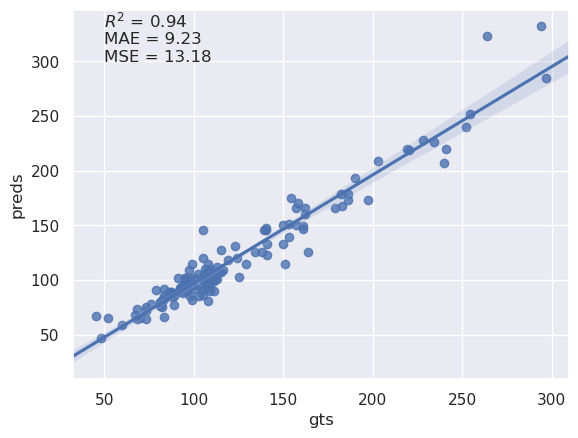

In [5]:
data = pd.DataFrame({'gts': gts, 'preds': preds})
sns.set_theme(style="darkgrid")

g = sns.regplot(x="gts", y="preds", data=data, truncate=False)
g.text(50, 300, f'$R^2$ = {round(r2, 2)}\nMAE = {round(mae, 2)}\nMSE = {round(rmse, 2)}')

## Evaluation on 2021 Enlarged Dataset

In [6]:
from pathlib import Path
p = Path('../data/2021_enlarged_dataset')

json_list = [item.absolute() for item in p.glob('**/*.json')]

model.eval()

gts = []
preds = []
ames = []
precisions = []
recalls = []
with torch.no_grad():
    for json_path in tqdm(json_list):
        with open(json_path, 'r') as f:
            json_file = json.load(f)

        img_name = img_url = json_file['item']['slots'][0]['source_files'][0]['file_name']
        img_path = f'../data/2021_enlarged_dataset/{img_name}'
        # print(img_url)
        img = iio.imread(img_path)
        points = get_points(json_file)
        img_tensor = transform(image=img)['image'].unsqueeze(0).to(device)

        bx0 = model(img_tensor, inference=True)
        rst = bx0.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        coordinates = peak_local_max(rst[..., 0], min_distance=10, threshold_abs=0.1)
    
        matched_distances_nn_cdist, matched_indices_pred_cdist, matched_indices_gt_cdist = matching(coordinates, points, match_threshold=25)

        ame = matched_distances_nn_cdist.sum() / len(matched_distances_nn_cdist)
        precision = len(matched_indices_pred_cdist) / len(coordinates)
        recall = len(matched_indices_pred_cdist) / len(points)
        
        ames.append(ame)
        precisions.append(precision)
        recalls.append(recall)

        preds.append(len(coordinates))
        
        annotations = json_file['annotations']
        gts.append(len(points))

100%|██████████| 378/378 [00:46<00:00,  8.21it/s]


In [7]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gts, preds)
r2 = r_value ** 2
mae = mean_absolute_error(gts, preds)
mse = mean_squared_error(gts, preds)
rmse = math.sqrt(mse)
mame = sum(ames) / len(ames)
mprecisions = sum(precisions) / len(precisions)
mrecall = sum(recalls) / len(recalls)
print(f'R2: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAME: {mame:.2f}')
print(f'P: {mprecisions:.2f}')
print(f'R: {mrecall:.2f}')
f1_score = cal_f1_score(mprecisions, mrecall)
print(f'F1_score: {f1_score:.2f}')

R2: 0.86
MAE: 13.69
RMSE: 18.32
MAME: 8.08
P: 0.81
R: 0.87
F1_score: 0.84


Text(20, 250, '$R^2$ = 0.86\nMAE = 13.69\nMSE = 335.57')

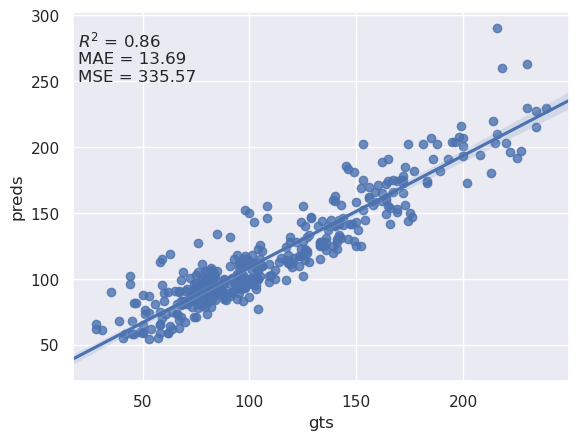

In [8]:
data = pd.DataFrame({'gts': gts, 'preds': preds})
sns.set_theme(style="darkgrid")

g = sns.regplot(x="gts", y="preds", data=data, truncate=False)
g.text(20, 250, f'$R^2$ = {round(r2, 2)}\nMAE = {round(mae, 2)}\nMSE = {round(mse, 2)}')

# Evaluation on 2022 Dataset

In [9]:
p = Path('../data/2022_dataset/')
data_annotation = '../data/2022_dataset/annotations'
imgpath_list = [item for item in p.glob('**/*.jpg')]

In [10]:
model.eval()

gts = []
preds = []
ames = []
precisions = []
recalls = []
with torch.no_grad():
    for imgpath in tqdm(imgpath_list):
        img_name = imgpath.name
        img_stem = imgpath.stem
        json_path = f'{data_annotation}/{img_stem}.json'
        with open(json_path, 'r') as f:
            json_file = json.load(f)

        img = iio.imread(imgpath)
        h, w, _ = img.shape
        points = get_points(json_file)

        img_tensor = transform(image=img)['image'].unsqueeze(0).to(device)
        bx0 = model(img_tensor, inference=True)

        rst = bx0.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        coordinates = peak_local_max(rst[..., 0], min_distance=10, threshold_abs=0.1)

        matched_distances_nn_cdist, matched_indices_pred_cdist, matched_indices_gt_cdist = matching(coordinates, points, match_threshold=25)

        ame = matched_distances_nn_cdist.sum() / len(matched_distances_nn_cdist)
        precision = len(matched_indices_pred_cdist) / len(coordinates)
        recall = len(matched_indices_pred_cdist) / len(points)
        
        ames.append(ame)
        precisions.append(precision)
        recalls.append(recall)
        
        preds.append(len(coordinates))
        gts.append(len(points))

100%|██████████| 250/250 [00:11<00:00, 20.98it/s]


In [11]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(gts, preds)
r2 = r_value ** 2
mae = mean_absolute_error(gts, preds)
mse = mean_squared_error(gts, preds)
rmse = math.sqrt(mse)
mame = sum(ames) / len(ames)
mprecisions = sum(precisions) / len(precisions)
mrecall = sum(recalls) / len(recalls)
print(f'R2: {r2:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAME: {mame:.2f}')
print(f'P: {mprecisions:.2f}')
print(f'R: {mrecall:.2f}')
f1_score = cal_f1_score(mprecisions, mrecall)
print(f'F1_score: {f1_score:.2f}')

R2: 0.82
MAE: 13.66
RMSE: 17.26
MAME: 4.99
P: 0.91
R: 0.85
F1_score: 0.88


Text(30, 270, '$R^2$ = 0.82\nMAE = 13.66\nMSE = 298.05')

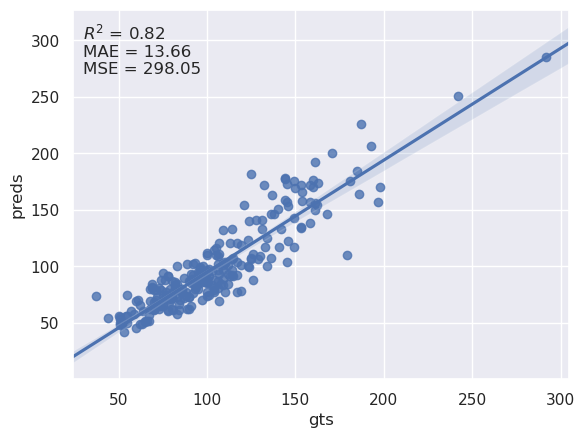

In [12]:
data = pd.DataFrame({'gts': gts, 'preds': preds})
sns.set_theme(style="darkgrid")

g = sns.regplot(x="gts", y="preds", data=data, truncate=False)
g.text(30, 270, f'$R^2$ = {round(r2, 2)}\nMAE = {round(mae, 2)}\nMSE = {round(mse, 2)}')